In [ ]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [12]:
original_df = pd.read_csv("../0. Data/classification_data.csv")
original_df = original_df.drop(columns=["Recycle ratio (total return sludge flow/total influent flow).1"])
original_df.columns.to_list()

['Sample',
 'Position',
 'Country',
 'City',
 'Plant',
 'Date',
 'Volume of aeration tanks (m3)',
 'Actual Inf rate (m3/d)',
 '℃ Temp.Max.SamplingDate',
 '℃ Temp.Avg.SamplingDate',
 '℃ Temp.Min.SamplingDate',
 '℃ Dew.Max.SamplingDate',
 '℃ Dew.Avg.SamplingDate',
 '℃ Dew.Min.SamplingDate',
 '℃ Humidity.Max.SamplingDate',
 '℃ Humidity.Min.SamplingDate',
 '℃ Wind.Max.SamplingDate',
 '℃ Wind.Min.SamplingDate',
 '℃ Pressure.Max.SamplingDate',
 '℃ Pressure.Min.SamplingDate',
 '℃ Precipitation.SamplingDate',
 '℃ Temp.Max.WeekMean',
 '℃ Temp.Avg.WeekMean',
 '℃ Temp.Min.WeekMean',
 '℃ Dew.Max.WeekMean',
 '℃ Dew.Avg.WeekMean',
 '℃ Dew.Min.WeekMean',
 '℃ Humidity.Max.WeekMean',
 '℃ Humidity.Min.WeekMean',
 '℃ Wind.Max.WeekMean',
 '℃ Wind.Min.WeekMean',
 '℃ Pressure.Max.WeekMean',
 '℃ Pressure.Min.WeekMean',
 '℃ Precipitation.WeekMean',
 '℃ Temp.Max.WeekMax',
 '℃ Temp.Avg.WeekMax',
 '℃ Temp.Min.WeekMax',
 '℃ Dew.Max.WeekMax',
 '℃ Dew.Avg.WeekMax',
 '℃ Dew.Min.WeekMax',
 '℃ Humidity.Max.WeekMax',
 

In [13]:
as_list = [
    'NewcastleAS', 'VarbergAS', 'SFAS',
    'Beijing3AS', 'Beijing2AS', 'GuangzhouAS',
    'KnoxvilleASP1', 'KnoxvilleASP2', 'KnoxvilleASP3',
    'DurbanASP1', 'DurbanASP2', 'DurbanASP3', 'DurbanASP4',
    'LisbonAS', 'ChicagoAS',
    'NormanASP1', 'NormanASP2', 'NormanASP3'
]

filtered_df = original_df[original_df["Position"].isin(as_list)]
len(as_list)
print(original_df["Position"].unique(), filtered_df["Position"].unique())

['NewcastleAS' 'VarbergAS' 'VarbergINF' 'SFAS' 'SFINF' 'Bejing3INF'
 'Beijing3AS' 'Beijing2AS' 'Beijing2INF' 'GuangzhouINF' 'GuangzhouAS'
 'KnoxvilleINF' 'KnoxvilleASP1' 'KnoxvilleASP2' 'KnoxvilleASP3'
 'DurbanASP1' 'DurbanASP2' 'DurbanASP3' 'DurbanASP4' 'LisbonINF'
 'LisbonAS' 'ChicagoAS' 'NormanINF' 'NormanASP1' 'NormanASP2' 'NormanASP3'
 'NormanEFF'] ['NewcastleAS' 'VarbergAS' 'SFAS' 'Beijing3AS' 'Beijing2AS' 'GuangzhouAS'
 'KnoxvilleASP1' 'KnoxvilleASP2' 'KnoxvilleASP3' 'DurbanASP1' 'DurbanASP2'
 'DurbanASP3' 'DurbanASP4' 'LisbonAS' 'ChicagoAS' 'NormanASP1'
 'NormanASP2' 'NormanASP3']


In [17]:
X_svd_df = pd.read_csv("../0. Data/relative_abundance_table.csv", index_col=0)
X_svd_df.columns = [f"SVD_{i+1}" for i in range(3125)]
X_svd_df

,SVD_1,SVD_2,SVD_3,SVD_4,SVD_5,SVD_6,SVD_7,SVD_8,SVD_9,SVD_10,...,SVD_3116,SVD_3117,SVD_3118,SVD_3119,SVD_3120,SVD_3121,SVD_3122,SVD_3123,SVD_3124,SVD_3125
UK01A,0.000000,0.097762,0.046419,0.000000,0.022739,0.042871,0.099573,0.0,0.006662,0.004055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK02A,0.000000,0.071315,0.048201,0.000000,0.021742,0.032205,0.100390,0.0,0.005618,0.003688,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK03A,0.000000,0.073343,0.048030,0.000000,0.020846,0.039139,0.088275,0.0,0.006509,0.004127,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK04A,0.000000,0.067344,0.041381,0.000000,0.026551,0.028988,0.111961,0.0,0.006134,0.003403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK05A,0.000000,0.067793,0.033581,0.000000,0.026604,0.036691,0.119363,0.0,0.005800,0.005800,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GZ101,0.000000,0.000000,0.000000,0.001453,0.000000,0.000000,0.000000,0.0,0.000436,0.008719,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GZ102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.001558,0.007414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GZ103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.001048,0.003370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GZ104,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.003751,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:

filtered_df_indexed = filtered_df.set_index("Sample")

# X_svd_df와 병합
merged_df = filtered_df_indexed.join(X_svd_df, how="inner")

# 결과 확인
print(merged_df.shape)
merged_df


(813, 3215)


,Position,Country,City,Plant,Date,Volume of aeration tanks (m3),Actual Inf rate (m3/d),℃ Temp.Max.SamplingDate,℃ Temp.Avg.SamplingDate,℃ Temp.Min.SamplingDate,...,SVD_3116,SVD_3117,SVD_3118,SVD_3119,SVD_3120,SVD_3121,SVD_3122,SVD_3123,SVD_3124,SVD_3125
UK01A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-01-28,3600.0,17254.0,6.67,3.33,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK02A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-04,3600.0,7007.0,5.56,3.33,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK03A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-11,3600.0,7197.0,5.56,4.44,2.78,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK04A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-18,3600.0,6126.0,11.67,10.00,8.89,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK05A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-25,3600.0,6898.0,10.56,7.78,5.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N48C,NormanASP3,United States,Norman,USNO2,2015-12-23,9751.2,31922.0,20.56,9.44,-1.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N49C,NormanASP3,United States,Norman,USNO2,2015-12-30,9751.2,45538.0,0.56,-2.22,-5.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N50C,NormanASP3,United States,Norman,USNO2,2016-01-06,9751.2,39274.0,11.67,8.33,4.44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N51C,NormanASP3,United States,Norman,USNO2,2016-01-13,9751.2,34284.0,14.44,5.56,-3.33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
merged_df["Position"].unique()

array(['NewcastleAS', 'VarbergAS', 'SFAS', 'Beijing3AS', 'Beijing2AS',
       'GuangzhouAS', 'KnoxvilleASP1', 'KnoxvilleASP2', 'KnoxvilleASP3',
       'DurbanASP1', 'DurbanASP2', 'DurbanASP3', 'DurbanASP4', 'LisbonAS',
       'ChicagoAS', 'NormanASP1', 'NormanASP2', 'NormanASP3'],
      dtype=object)

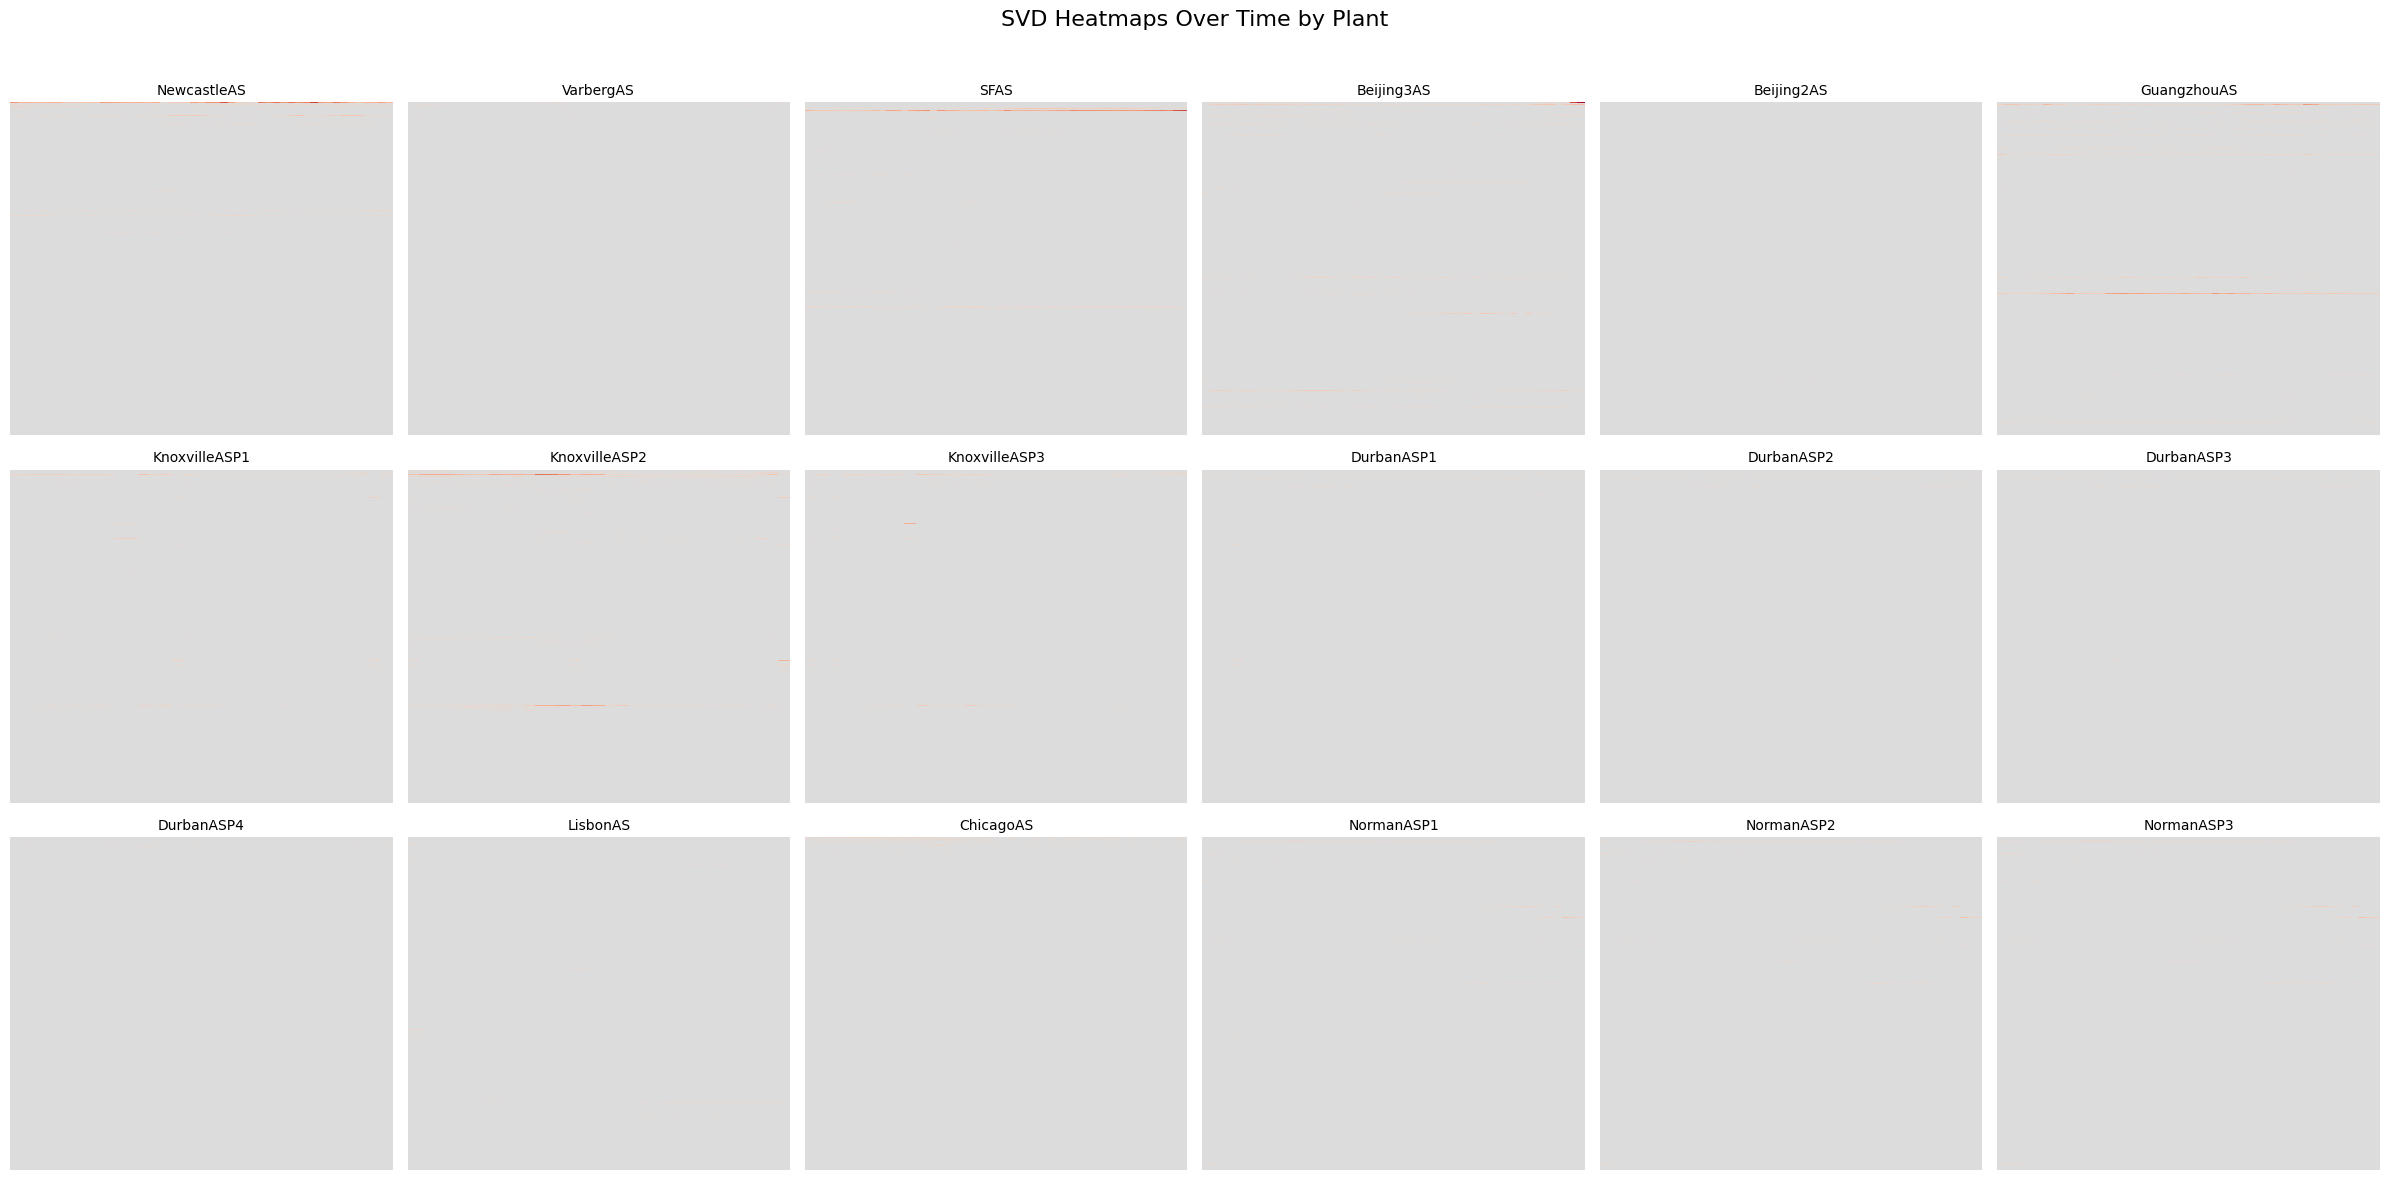

In [20]:


# SVD 컬럼
svd_cols = [col for col in merged_df.columns if col.startswith("SVD_")]

# Date를 datetime으로 변환
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# Plant 리스트 (상위 18개만 사용)
plant_list = merged_df["Position"].unique()[:18]

# 서브플롯 설정
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24, 12))
axes = axes.flatten()

for i, plant_name in enumerate(plant_list):
    ax = axes[i]

    group_df = merged_df[merged_df["Position"] == plant_name].sort_values("Date")

    if group_df.shape[0] < 3:
        ax.set_visible(False)
        continue

    group_df = group_df.set_index("Date")
    svd_data = group_df[svd_cols].T  # SVDs on y-axis

    sns.heatmap(svd_data, cmap="coolwarm", center=0, ax=ax,
                cbar=False, xticklabels=False, yticklabels=False)

    ax.set_title(plant_name, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")

# 전체 레이아웃 조정
plt.suptitle("SVD Heatmaps Over Time by Plant", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [23]:
plant_list

array(['NewcastleAS', 'VarbergAS', 'SFAS', 'Beijing3AS', 'Beijing2AS',
       'GuangzhouAS', 'KnoxvilleASP1', 'KnoxvilleASP2', 'KnoxvilleASP3',
       'DurbanASP1', 'DurbanASP2', 'DurbanASP3', 'DurbanASP4', 'LisbonAS',
       'ChicagoAS', 'NormanASP1', 'NormanASP2', 'NormanASP3'],
      dtype=object)

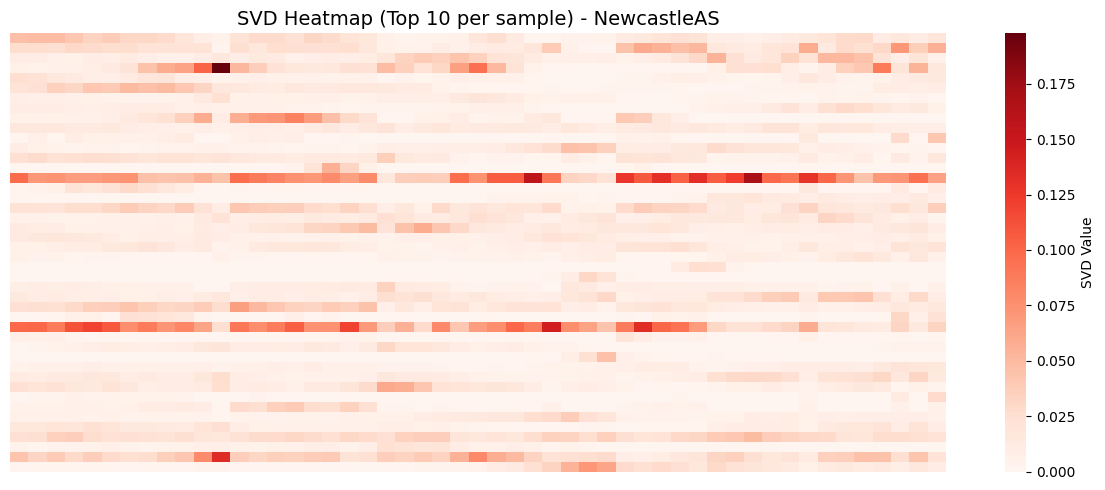

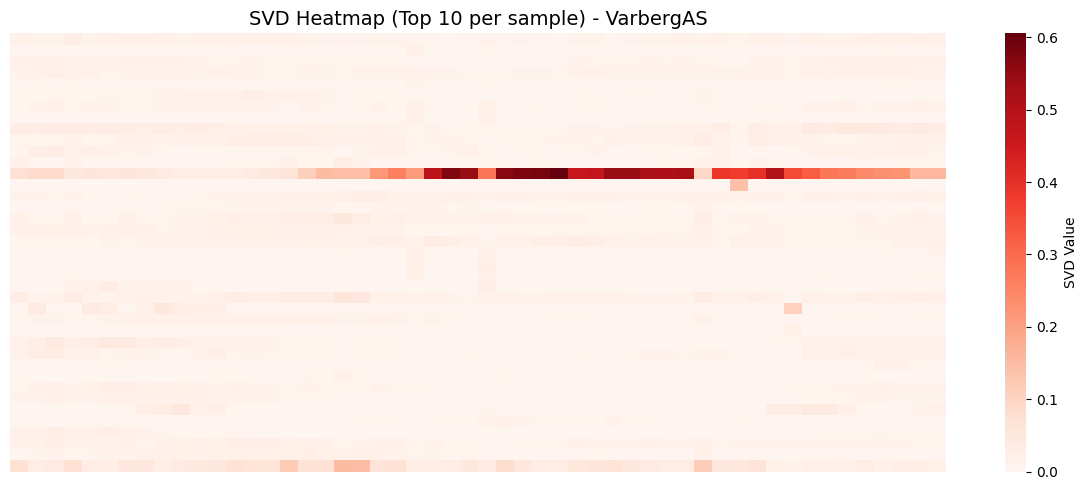

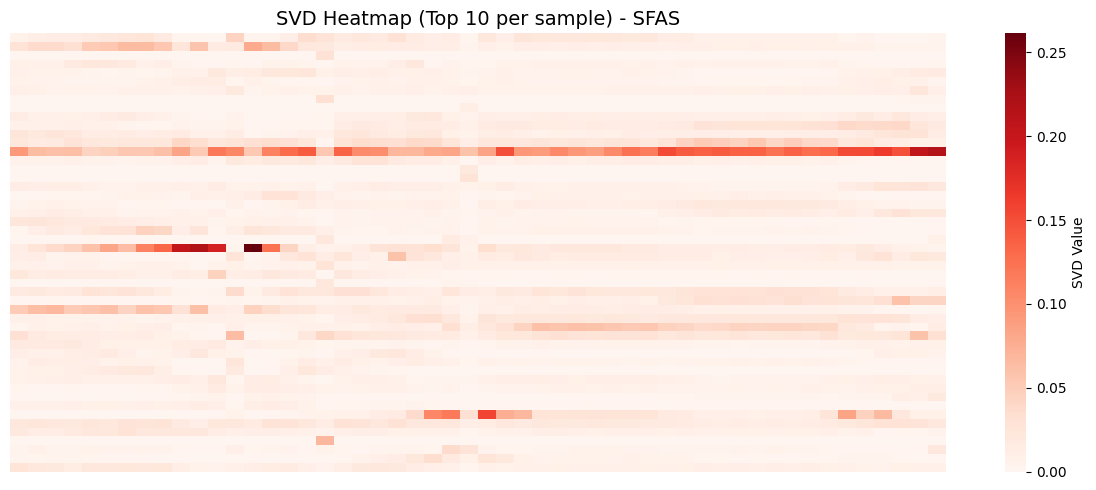

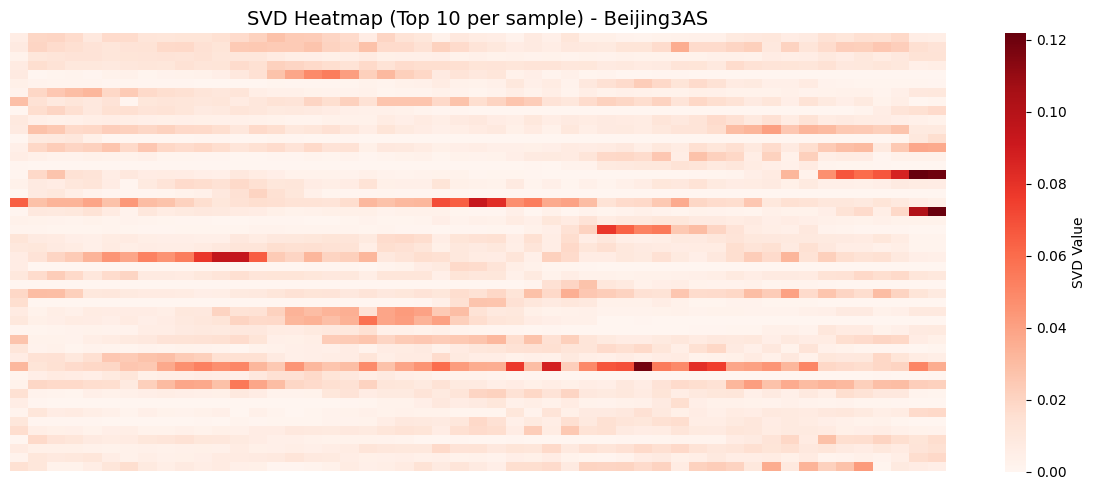

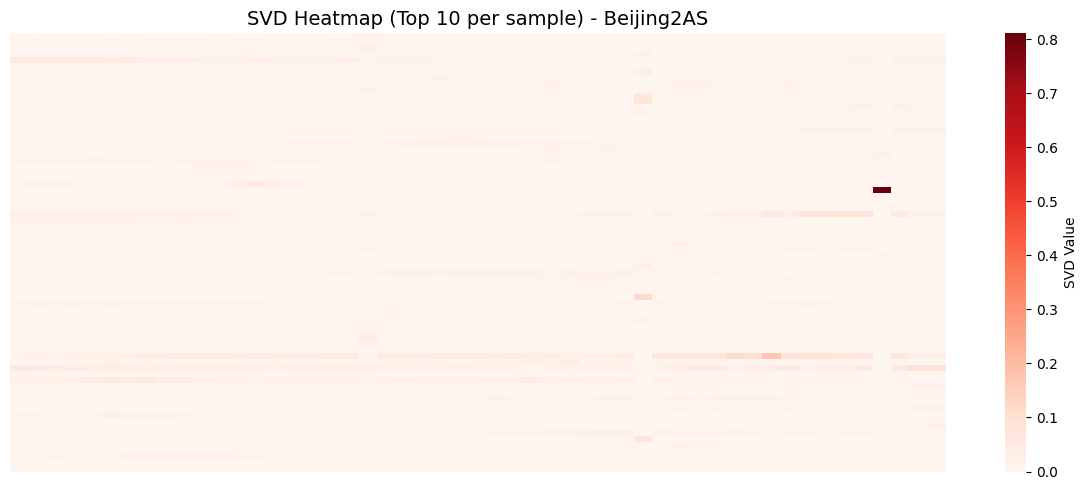

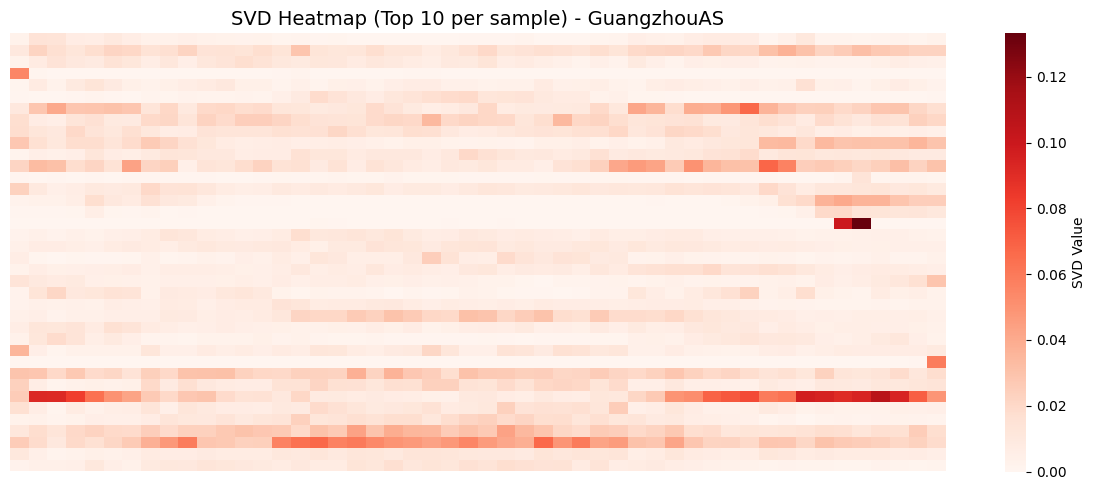

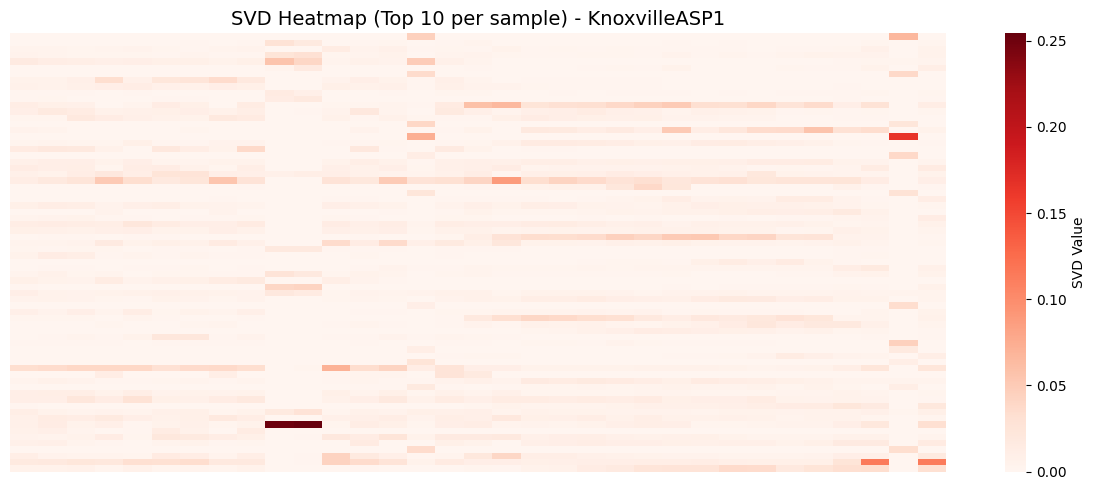

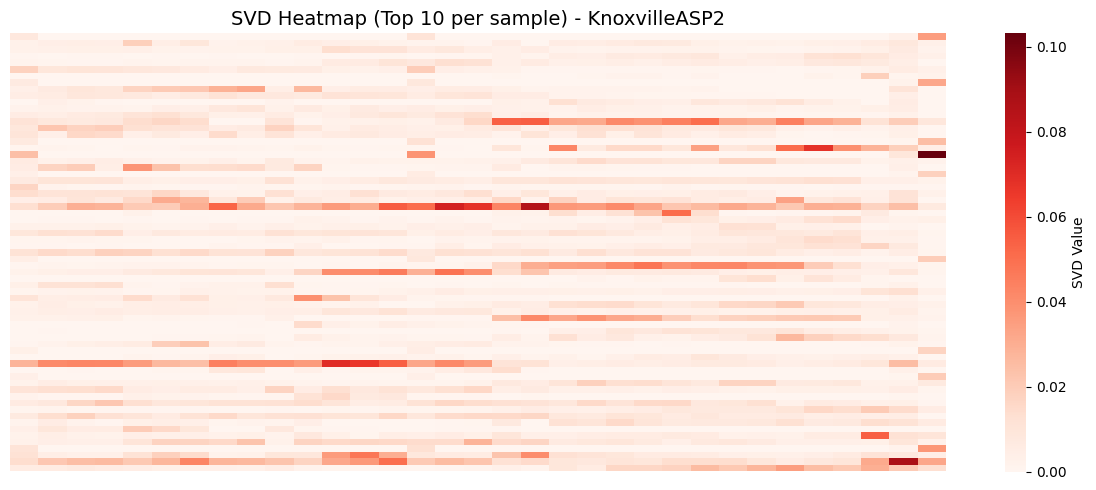

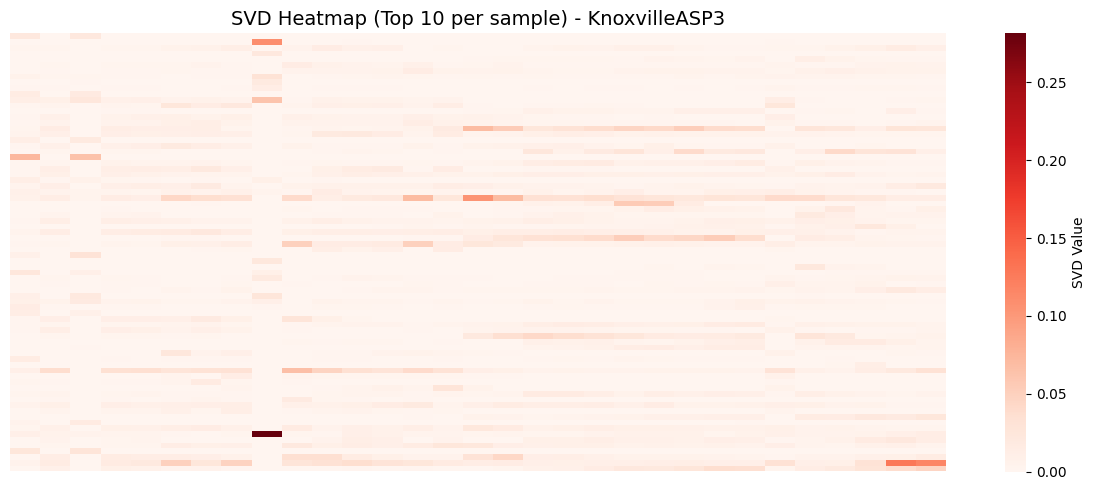

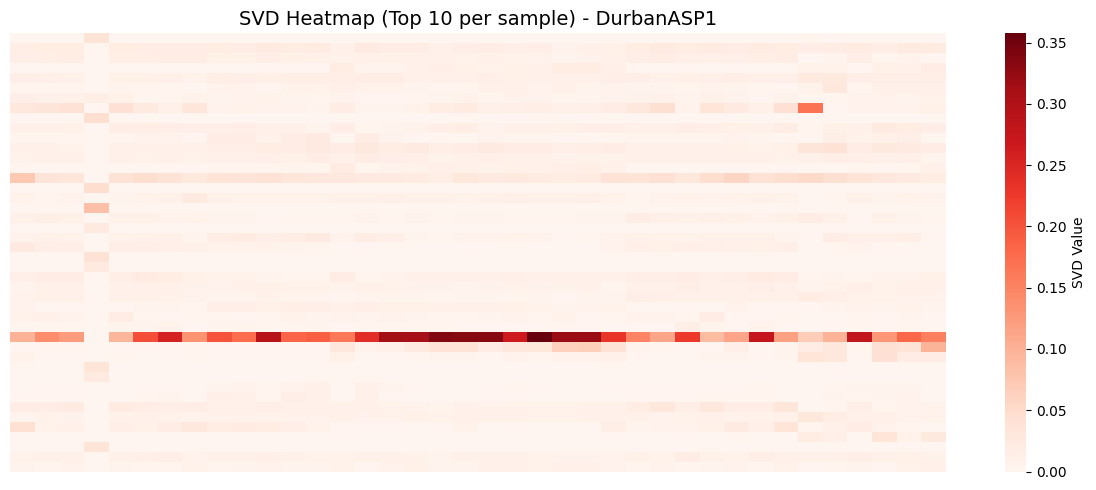

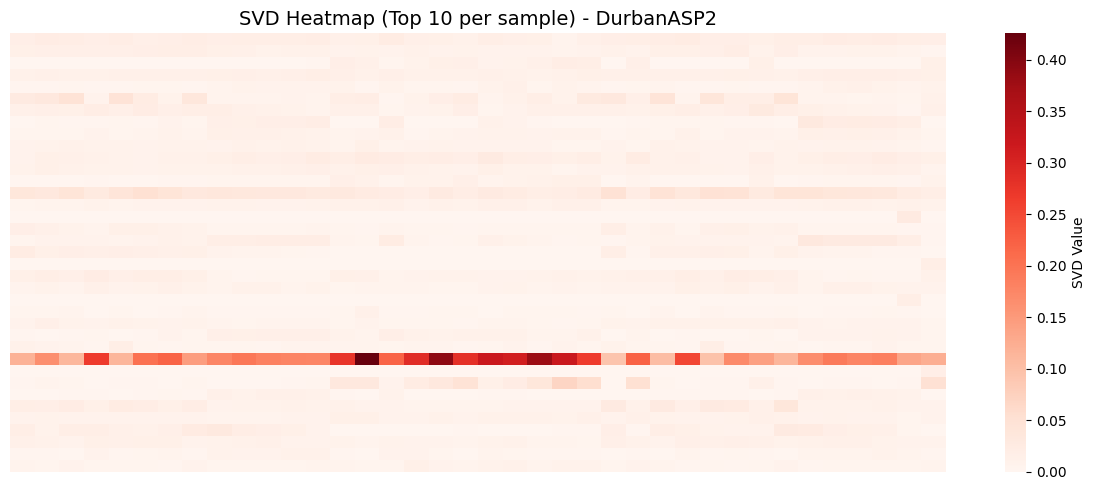

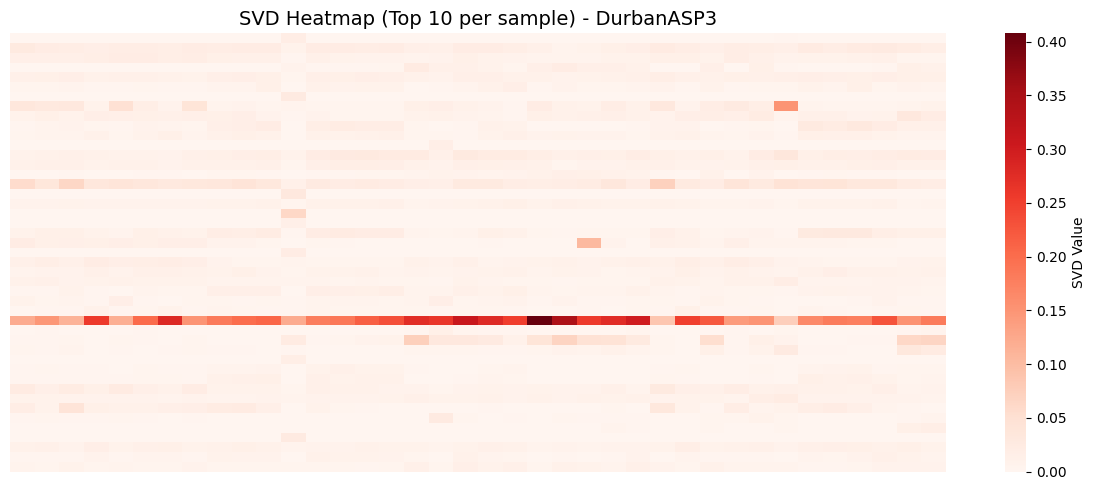

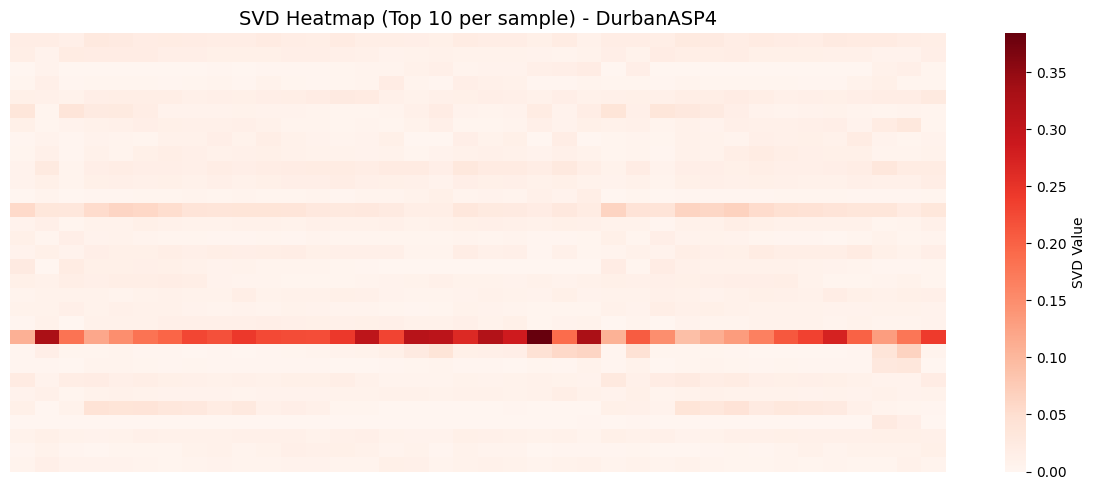

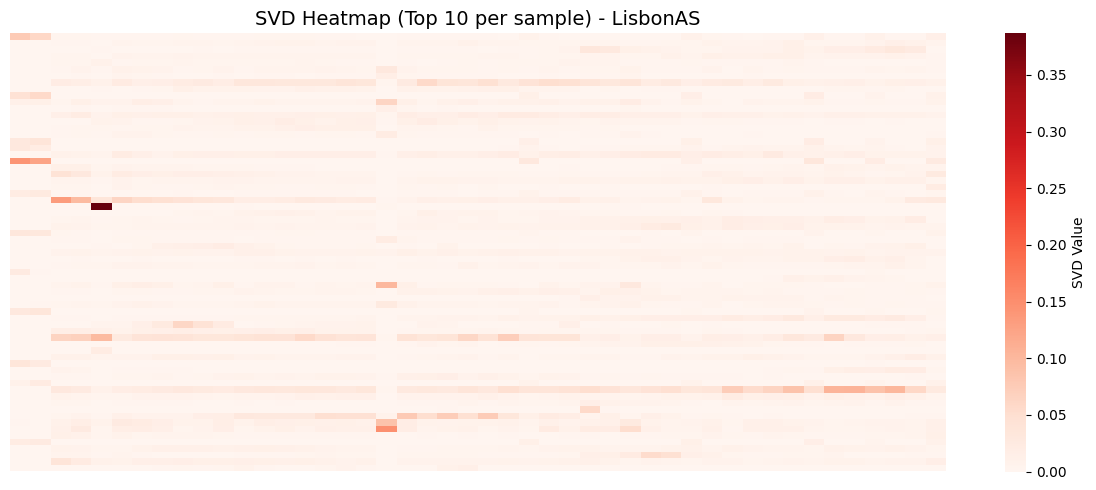

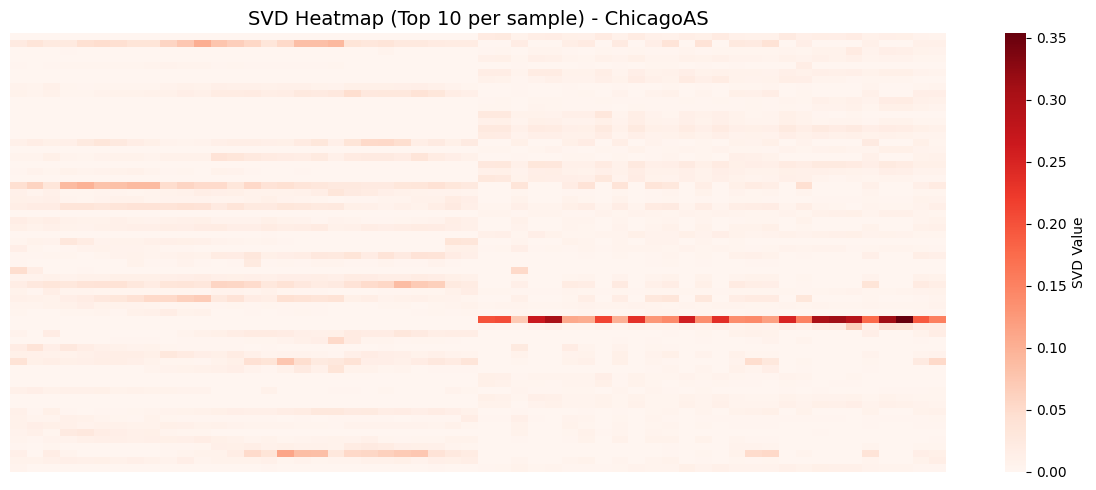

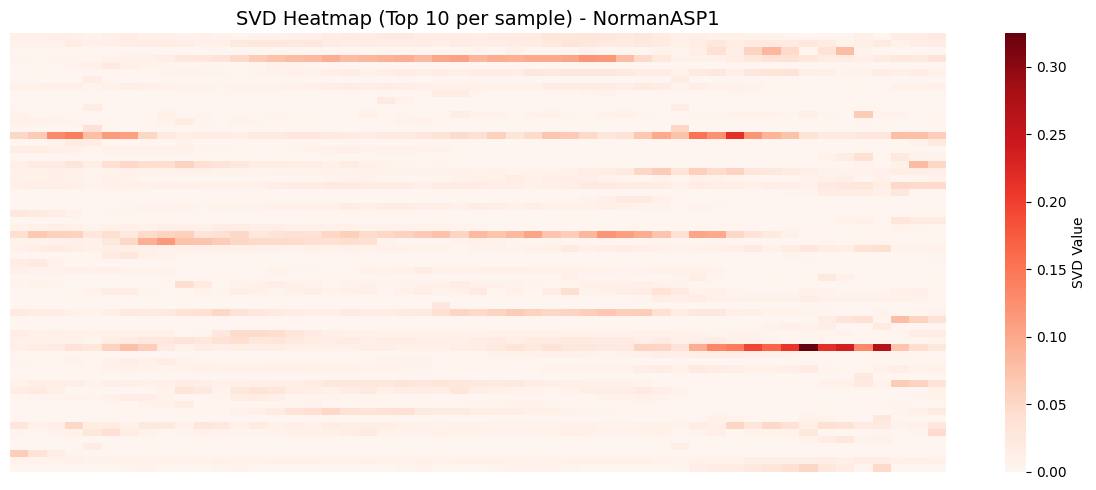

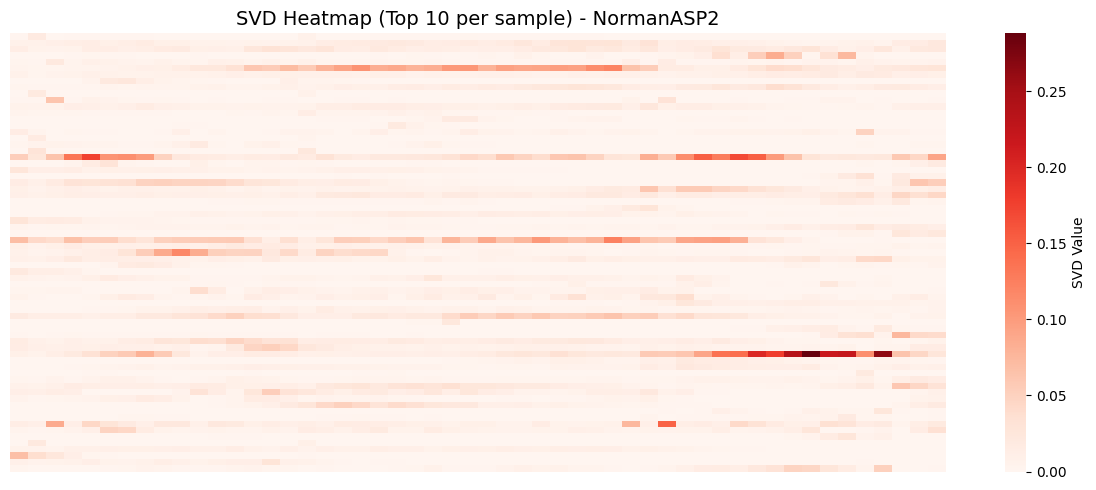

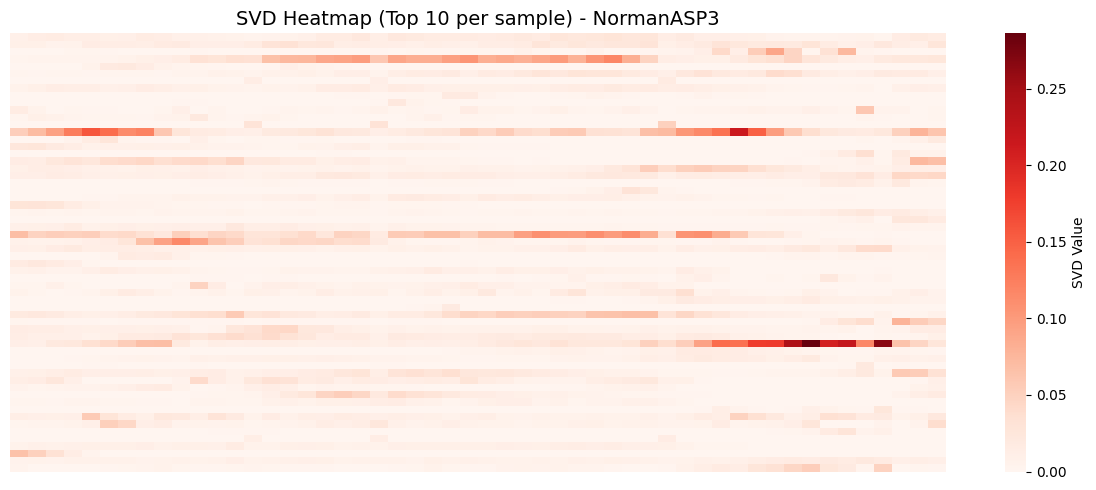

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# SVD 컬럼 리스트
svd_cols = [col for col in merged_df.columns if col.startswith("SVD_")]

# 날짜 처리
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# 플랜트 리스트
plant_list = merged_df["Position"].unique()[:18]

for plant_name in plant_list:
    group_df = merged_df[merged_df["Position"] == plant_name].sort_values("Date")

    if group_df.shape[0] < 3:
        continue

    group_df = group_df.set_index("Date")
    svd_only = group_df[svd_cols]

    # 각 row(날짜)에 대해 상위 10개 SVD 컬럼만 남기기
    top10_svd_cols = svd_only.apply(lambda row: row.nlargest(10).index, axis=1)
    top_svd_set = set(top10_svd_cols.explode())  # 유니크한 컬럼만 추출

    # 필터링된 SVD 데이터 (상위 10개 컬럼만 유지)
    filtered_svd = svd_only[list(top_svd_set)].T

    # 히트맵 그리기
    plt.figure(figsize=(12, 5))
    sns.heatmap(
        filtered_svd,
        cmap="Reds",
        cbar_kws={'label': 'SVD Value'},
        xticklabels=False,
        yticklabels=False
    )

    plt.title(f"SVD Heatmap (Top 10 per sample) - {plant_name}", fontsize=14)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()


## 차원축소된 데이터 플럿
